# Attribute Information

<ol>
    <li>age</li>
    <li>job : type of job</li>
    <li>marital : marital status</li>
    <li>education</li>
    <li>default: has credit in default?</li>
    <li>housing: has housing loan?</li>
    <li>loan: has personal loan?</li>
    <li>balance in account</li>
    <li>contact: contact communication type</li>
    <li>month: last contact month of year</li>
    <li>day: last contact day of the month</li>
    <li>duration: last contact duration, in seconds</li>
    <li>campaign: number of contacts performed during this campaign and for this client</li>
    <li>pdays: number of days that passed by after the client was last contacted from a previous campaign</li>
    <li>previous: number of contacts performed before this campaign and for this client</li>
    <li>poutcome: outcome of the previous marketing campaign</li>
    <li>Output variable ('Target'): has the client subscribed a term deposit?</li>
</ol>

In [1]:
#importing required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import graphviz
from IPython.display import display
from sklearn import tree

In [2]:
#read the csv data into pandas dataframe
bank_data = pd.read_csv('bank-full.csv')
bank_data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no

In [3]:
#get the info of the data which gives the data types
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
#find the shape of the data
bank_data.shape

(45211, 17)

In [5]:
#Look for any null values exists in the data
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

`It seems there are no null values in the data`

In [6]:
#look for any duplicate records exists in the data
bank_data[bank_data.duplicated()].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

`there are no duplicate records in the data`

In [7]:
#the numerical value of the day column has no specific weightage over other value. For example, day 1 of the month and
# day 30th of the month are equal. If we provide the data as-is to the model, it might treat as if day 30th has more weight.
# so converting day column into 4 weeks of the month and dropping day column.
conditions = [bank_data['day']<=7, 
              (bank_data['day'] > 7) & (bank_data['day']<=14),
              (bank_data['day'] > 14) & (bank_data['day']<=21),
              bank_data['day'] > 21]
labels = ['firstweek', 'secondweek', 'thirdweek','forthweek']
bank_data['week of the month'] = np.select(conditions, labels, default=np.nan)
bank_data['week of the month'].astype('object')
#Since we mapped day column to week of the month, dropping day column
bank_data.drop('day', axis=1, inplace=True)
bank_data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact month  duration  campaign  pdays  previous poutcome Target  \
0  unknown   may       261         1     -1         0  unknown     no   
1  unknown   may       151         1     -1         0  unknown     no   
2  unknown   may        76         1     -1         0  unknown     no   
3  unknown   may        92         1     -1         0  unknown     no   
4  unknown   may       198         1     -1         0  unknown     no   

  week of the month  
0         firstweek  
1         firstweek  
2         firstweek  
3         firstweek  
4         firstweek

In [8]:
#Checking pdays column with vaule 999. As 999 means the customer never contacted before
bank_data[bank_data['pdays']==999]

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, month, duration, campaign, pdays, previous, poutcome, Target, week of the month]
Index: []

In [9]:
#Since pdays means - number of days that passed by after the client was last contacted from a previous campaign, 
# so it cannot be negative. Lets treat the pdays column by taking absolute value of it
bank_data['pdays'] = bank_data['pdays'].abs()
bank_data[bank_data['pdays']<0]

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, month, duration, campaign, pdays, previous, poutcome, Target, week of the month]
Index: []

In [10]:
#Checking to see if we have negative balance
bank_data[bank_data['balance'] < 0]

age          job   marital  education default  balance housing loan  \
25      44       admin.   married  secondary      no     -372     yes   no   
28      46   management    single  secondary      no     -246     yes   no   
36      25  blue-collar   married  secondary      no       -7     yes   no   
37      53   technician   married  secondary      no       -3      no   no   
45      36       admin.    single    primary      no     -171     yes   no   
...    ...          ...       ...        ...     ...      ...     ...  ...   
44626   31     services    single  secondary      no     -205      no   no   
44629   28  blue-collar    single  secondary      no      -46     yes   no   
44836   33  blue-collar   married    primary      no     -195      no   no   
44908   48   management  divorced   tertiary      no     -130     yes   no   
44964   21  blue-collar    single    primary      no      -42      no   no   

        contact month  duration  campaign  pdays  previous poutcome Target  \
25      unknown   may       172         1      1         0  unknown     no   
28      unknown   may       255         2      1         0  unknown     no   
36      unknown   may       365         1      1         0  unknown     no   
37      unknown   may      1666         1      1         0  unknown     no   
45      unknown   may       242         1      1         0  unknown     no   
...         ...   ...       ...       ...    ...       ...      ...    ...   
44626  cellular   sep       481         1    579         1  failure    yes   
44629  cellular   sep       199         1     92        14  success    yes   
44836   unknown   sep         9         1      1         0  unknown     no   
44908  cellular   sep       110         2     61         9  failure     no   
44964   unknown   oct         5         1      1         0  unknown     no   

      week of the month  
25            firstweek  
28            firstweek  
36            firstweek  
37            firstweek  
45            firstweek  
...                 ...  
44626         firstweek  
44629         firstweek  
44836         thirdweek  
44908         forthweek  
44964        secondweek  

[3766 rows x 17 columns]

<h3> 'balance' column has negative values, I am not going to treat this column assuming that the bank allows overdraft </h3>

In [11]:
#get the description with 5 point summary and other statistics of the data
bank_data_description = bank_data.describe().transpose()
bank_data_description['range'] = bank_data_description['max'] - bank_data_description['min']
bank_data_description['median'] = bank_data.median()
bank_data_description['IQR'] = bank_data.quantile(0.75) - bank_data.quantile(0.25)
bank_data_description['Skewness'] = bank_data.skew()
bank_data_description

count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    41.832563    99.456849     1.0    1.0    1.0     1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   

               max     range  median     IQR   Skewness  
age           95.0      77.0    39.0    15.0   0.684818  
balance   102127.0  110146.0   448.0  1356.0   8.360308  
duration    4918.0    4918.0   180.0   216.0   3.144318  
campaign      63.0      62.0     2.0     2.0   4.898650  
pdays        871.0     870.0     1.0     0.0   2.627828  
previous     275.0     275.0     0.0     0.0  41.846454

# Univariate Analysis

In [12]:
#function to get the list of categorical and numerical columns
def get_categorical_and_numerical_columns():
    cols = bank_data.columns
    numerical_columns = bank_data._get_numeric_data().columns
    categorical_columns = list(set(cols)- set(numerical_columns))
    return numerical_columns, categorical_columns
numerical_columns, categorical_columns = get_categorical_and_numerical_columns()

In [13]:
# Finding the value counts of categorical columns
for col in categorical_columns:
    print(bank_data[col].value_counts())

no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
thirdweek     13900
forthweek     11071
secondweek    10442
firstweek      9798
Name: week of the month, dtype: int64
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: co

# Insights

1. The data has less credit defaulters
2. We have less subscriptions for the term deposit. Over 88% of the people did not subscribed for term deposit
3. For more than 81% of the data we don't know the outcome of previous campaign
4. More than 51% of the people has secondary education
5. More than 83% of people doesn't have personal loan
6. Major mode of communication with the customers is by cellular phone
7. It seems most people are contacted by the bank in the month of May
8. Highest number of people are in blue-collar and mangement jobs

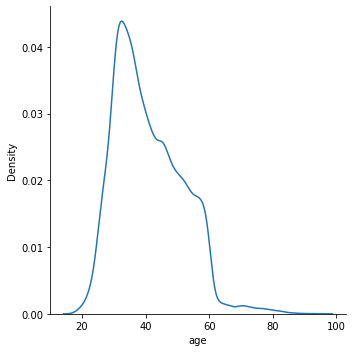

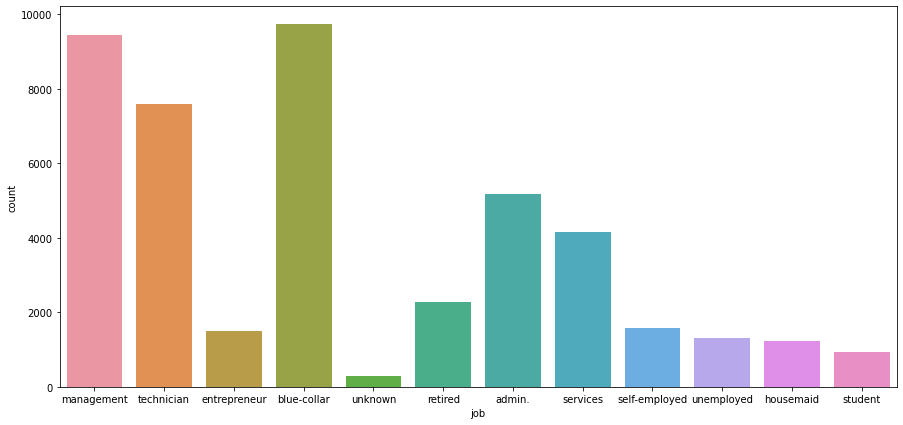

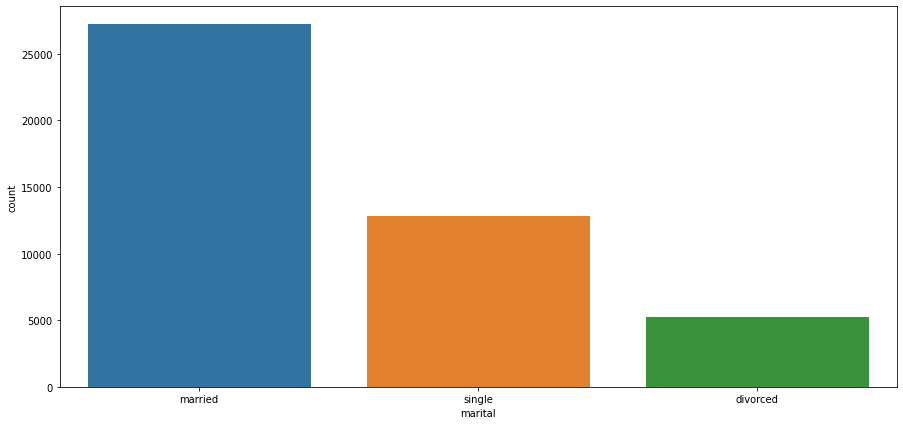

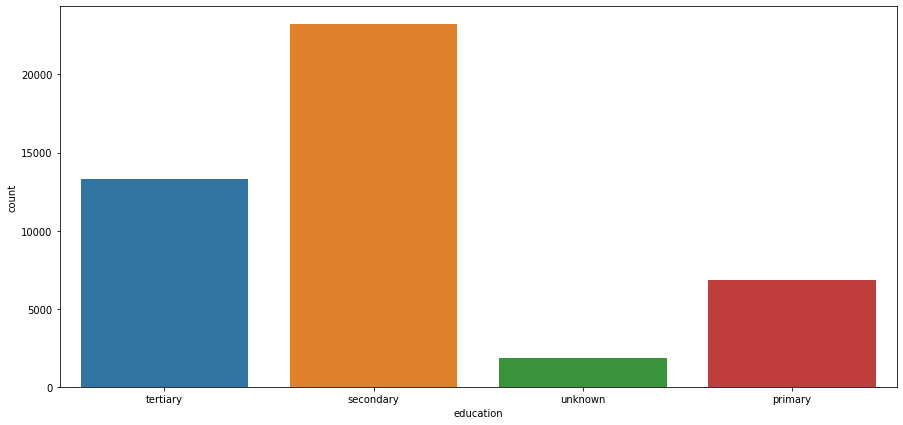

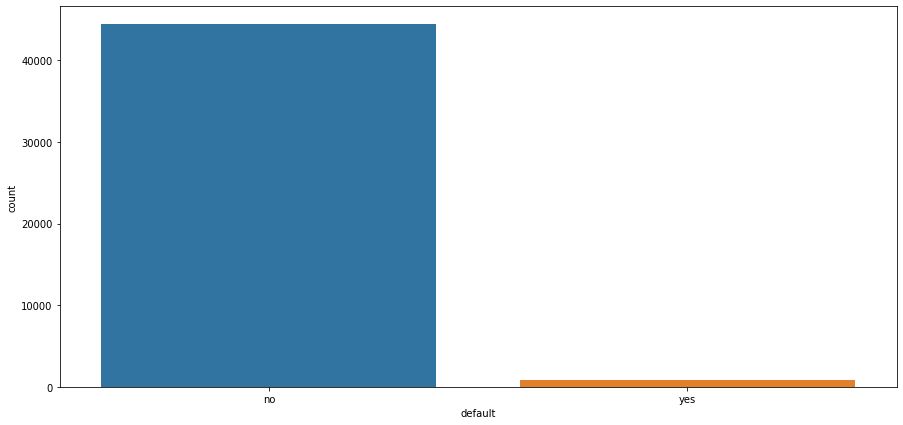

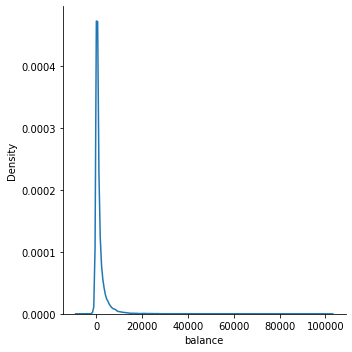

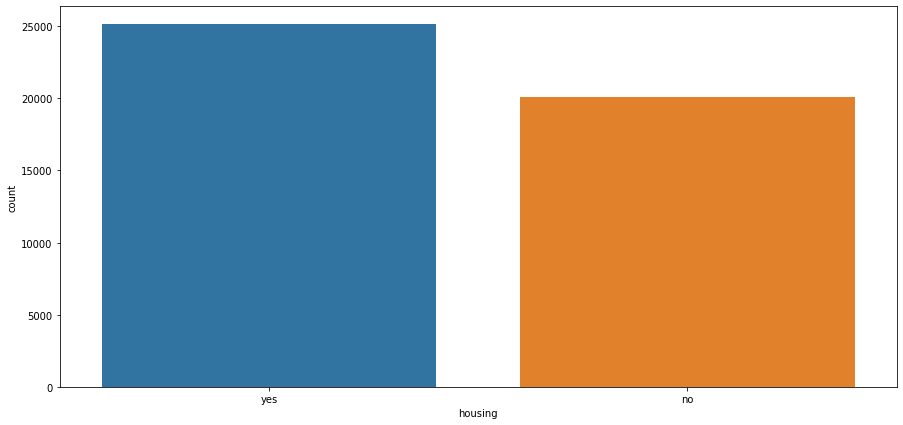

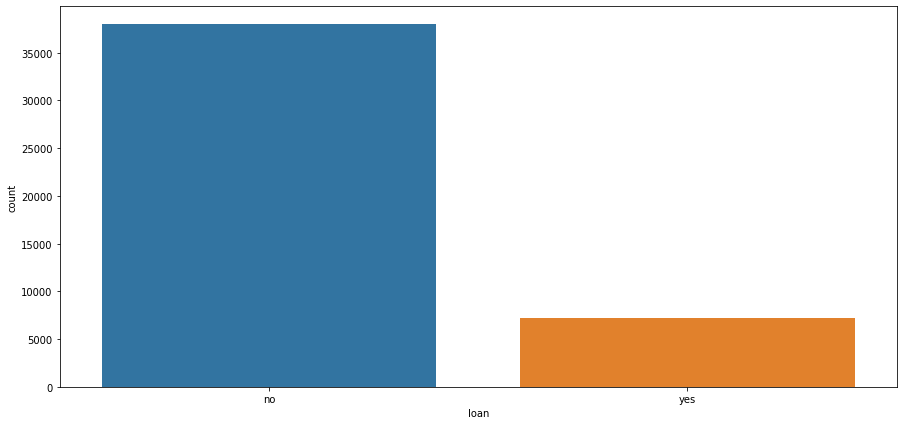

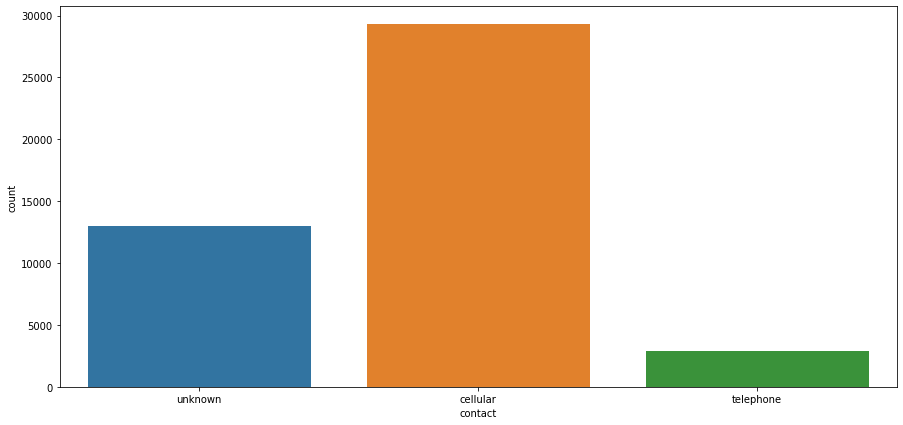

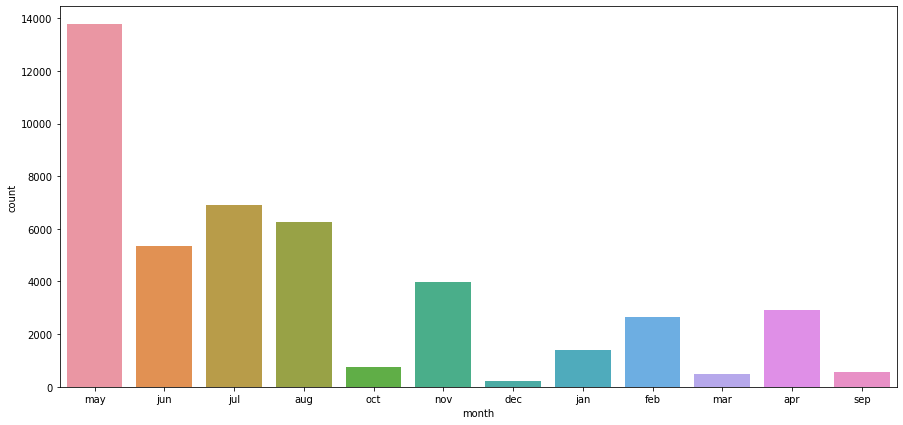

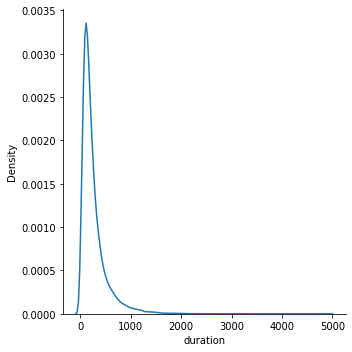

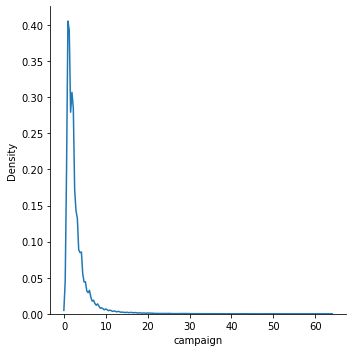

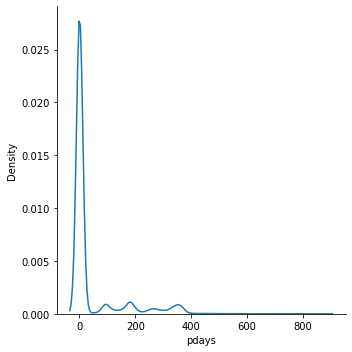

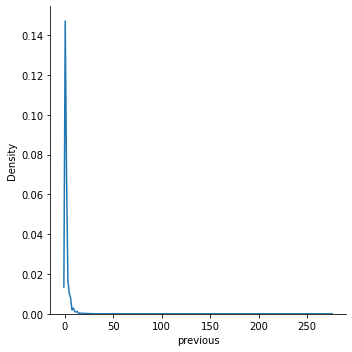

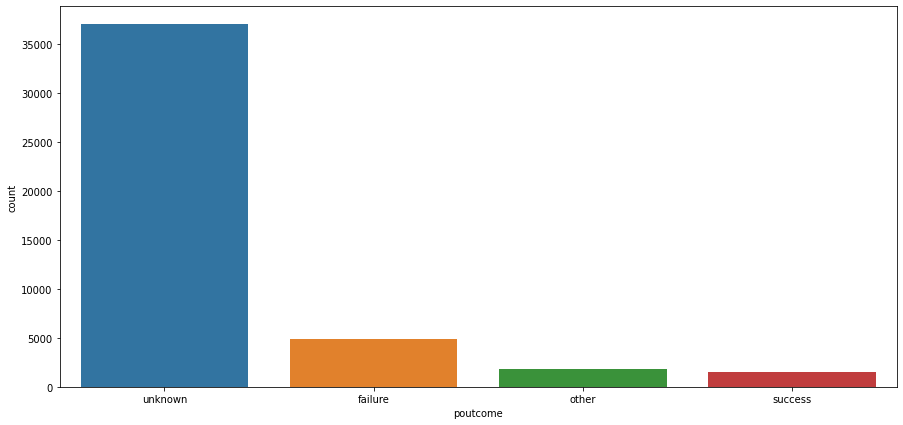

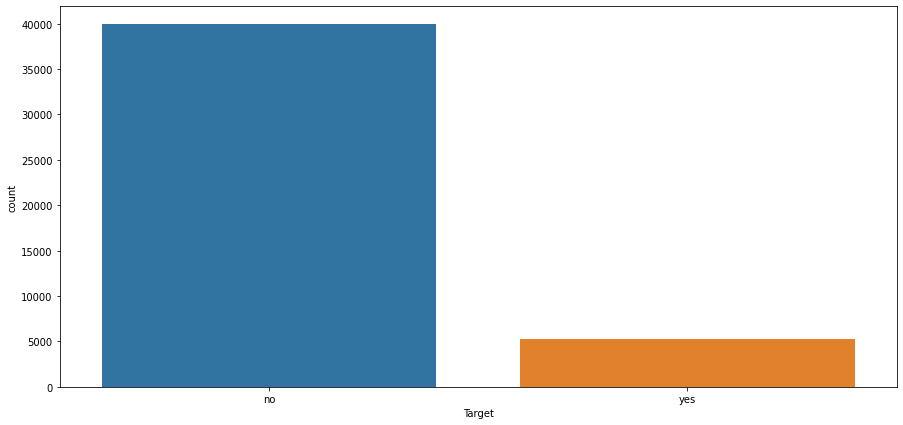

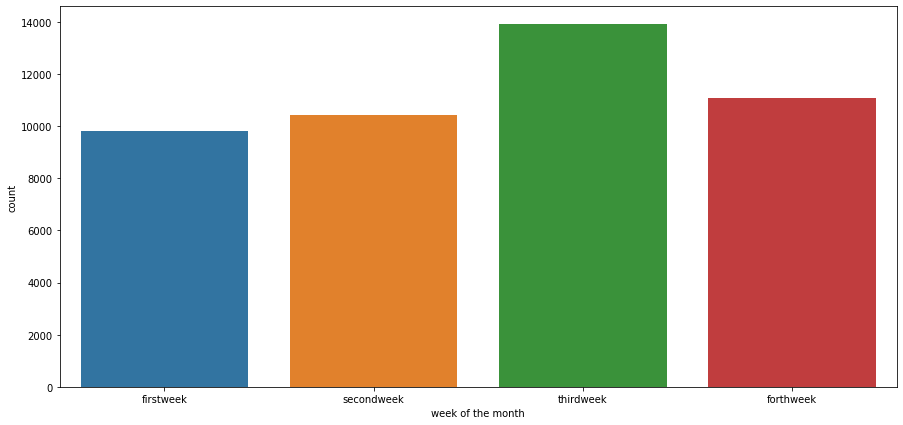

In [14]:
# Function to plot distribution plots for numberical columns and count plots for categorical columns
def plotgraphs(data):
    plt.rcParams['figure.figsize'] = (15,7)
    for col in data.columns:
        if col in numerical_columns:
            sns.displot(data[col], kind='kde')
        else:
            sns.countplot(data[col])
        plt.show()

plotgraphs(bank_data)

# Insights

1. age, balance, duration, campaign, pdays, previous columns data is not normally distributed and right skewed.
2. Failure outcome from the previous campaign is more compare to success

In [15]:
#normalizing numerical data using standard scaler
standardScaler = StandardScaler()
for col in numerical_columns:
  bank_data[col] = standardScaler.fit_transform(bank_data[[col]])
bank_data.head()

age           job  marital  education default   balance housing loan  \
0  1.606965    management  married   tertiary      no  0.256419     yes   no   
1  0.288529    technician   single  secondary      no -0.437895     yes   no   
2 -0.747384  entrepreneur  married  secondary      no -0.446762     yes  yes   
3  0.571051   blue-collar  married    unknown      no  0.047205     yes   no   
4 -0.747384       unknown   single    unknown      no -0.447091      no   no   

   contact month  duration  campaign    pdays  previous poutcome Target  \
0  unknown   may  0.011016 -0.569351 -0.41056  -0.25194  unknown     no   
1  unknown   may -0.416127 -0.569351 -0.41056  -0.25194  unknown     no   
2  unknown   may -0.707361 -0.569351 -0.41056  -0.25194  unknown     no   
3  unknown   may -0.645231 -0.569351 -0.41056  -0.25194  unknown     no   
4  unknown   may -0.233620 -0.569351 -0.41056  -0.25194  unknown     no   

  week of the month  
0         firstweek  
1         firstweek  
2         firstweek  
3         firstweek  
4         firstweek

In [16]:
#Identifying outliers
IQR = bank_data_description['IQR']
Q1 = bank_data.quantile(0.25)
Q3 = bank_data.quantile(0.75)

outlier_row_index = np.where((bank_data< Q1 - 1.5 * IQR) | (bank_data > Q3 + 1.5* IQR))[0]
bank_data_outliers = bank_data.iloc[outlier_row_index, : ]
bank_data_outliers

age           job   marital  education default   balance housing  \
2626  -0.935732    technician   married  secondary      no -0.412605     yes   
2706   0.476877        admin.  divorced   tertiary      no  0.783888     yes   
2967  -0.370689    technician   married   tertiary     yes -0.447419     yes   
3044   0.947747    unemployed   married  secondary      no -0.307834     yes   
3079  -1.218254   blue-collar   married    primary      no -0.447419      no   
...         ...           ...       ...        ...     ...       ...     ...   
45204  3.019575       retired   married  secondary      no  0.488624      no   
45208  2.925401       retired   married  secondary      no  1.429593      no   
45208  2.925401       retired   married  secondary      no  1.429593      no   
45210 -0.370689  entrepreneur   married  secondary      no  0.528364      no   
45210 -0.370689  entrepreneur   married  secondary      no  0.528364      no   

      loan   contact month  duration  campaign     pdays  previous poutcome  \
2626    no   unknown   may -0.610283  3.304133 -0.410560 -0.251940  unknown   
2706    no   unknown   may -0.734543  5.240875 -0.410560 -0.251940  unknown   
2967    no   unknown   may -0.641348  3.626923 -0.410560 -0.251940  unknown   
3044    no   unknown   may  0.108094  3.626923 -0.410560 -0.251940  unknown   
3079    no   unknown   may -0.936465  6.854826 -0.410560 -0.251940  unknown   
...    ...       ...   ...       ...       ...       ...       ...      ...   
45204   no  cellular   nov  0.162458 -0.569351 -0.018426  3.221163  failure   
45208   no  cellular   nov  3.373797  0.721811  1.429454  1.050473  success   
45208   no  cellular   nov  3.373797  0.721811  1.429454  1.050473  success   
45210   no  cellular   nov  0.399328 -0.246560  1.469673  4.523577    other   
45210   no  cellular   nov  0.399328 -0.246560  1.469673  4.523577    other   

      Target week of the month  
2626      no        secondweek  
2706      no        secondweek  
2967      no        secondweek  
3044      no        secondweek  
3079      no        secondweek  
...      ...               ...  
45204    yes         thirdweek  
45208    yes         thirdweek  
45208    yes         thirdweek  
45210     no         thirdweek  
45210     no         thirdweek  

[17339 rows x 17 columns]

In [17]:
#Function to get total outliers per feature
def get_outliers(data):
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    return outliers
outliers = get_outliers(bank_data)
outliers

Target                  0
age                     0
balance                 0
campaign              840
contact                 0
default                 0
duration                0
education               0
housing                 0
job                     0
loan                    0
marital                 0
month                   0
pdays                8242
poutcome                0
previous             8257
week of the month       0
dtype: int64

In [18]:
#Finding the percentage of outliers
percentage_of_outliers = (outliers/len(bank_data)) * 100
percentage_of_outliers

Target                0.000000
age                   0.000000
balance               0.000000
campaign              1.857955
contact               0.000000
default               0.000000
duration              0.000000
education             0.000000
housing               0.000000
job                   0.000000
loan                  0.000000
marital               0.000000
month                 0.000000
pdays                18.230077
poutcome              0.000000
previous             18.263255
week of the month     0.000000
dtype: float64

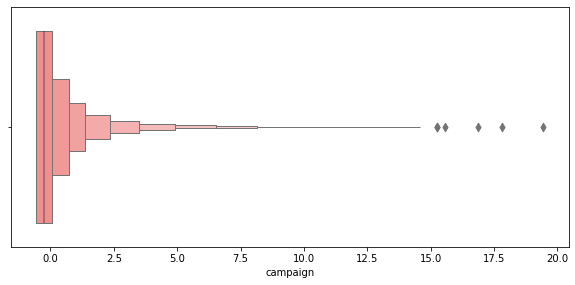

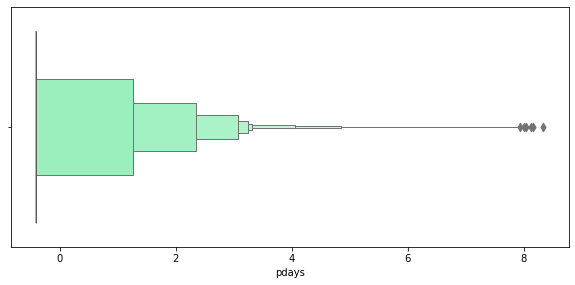

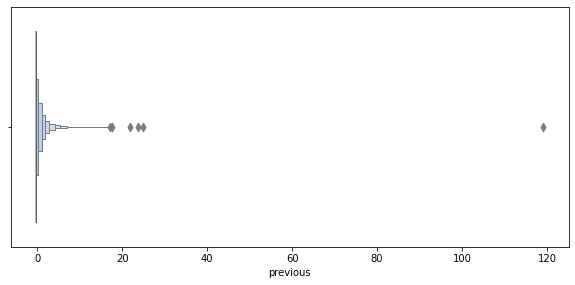

In [152]:
# Columns campaign, pdays and previous have outliers. lets plot the graphs to see the outliers visually.
columns_with_outliers = ['campaign', 'pdays', 'previous']

#Function to plot outliers
def plot_outliers():
    palettes = ['spring', 'rainbow', 'pastel']
    plt.rcParams['figure.figsize'] = (10,15)
    for index, col in enumerate(columns_with_outliers):
        plt.subplot(3, 1, index+1)
        sns.boxenplot(bank_data[col], palette=palettes[index])
        plt.show()
plot_outliers()

# Insights

1. We have 18% of the data as outliers for `pdays` and `previous` columns
2. `campaign` columns has outliers of 1.8%

We have significant outliers, we need to treat them because they might cause the model to be overfit and resulting in high variance with test data. Models like Decision tree, Adaboost are very sensitive to outliers. Because its good practice to fix the outliers only in training data instead of fixing the whole data set, we will treat them once we split the data in to test and train.

# Multivariate analysis

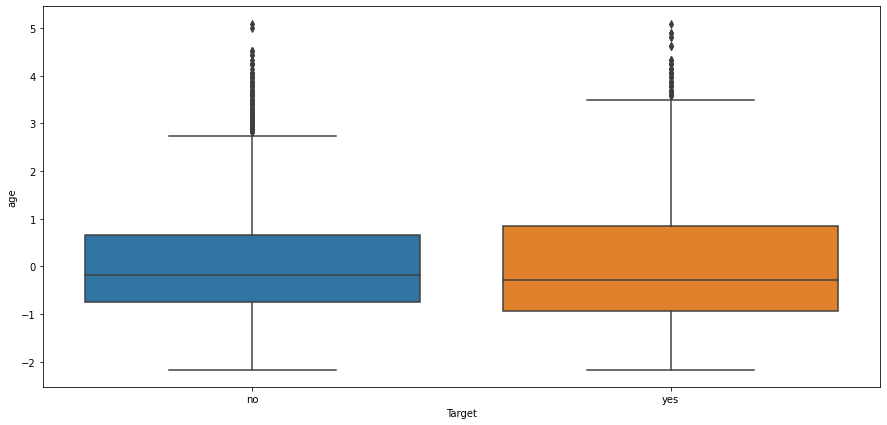

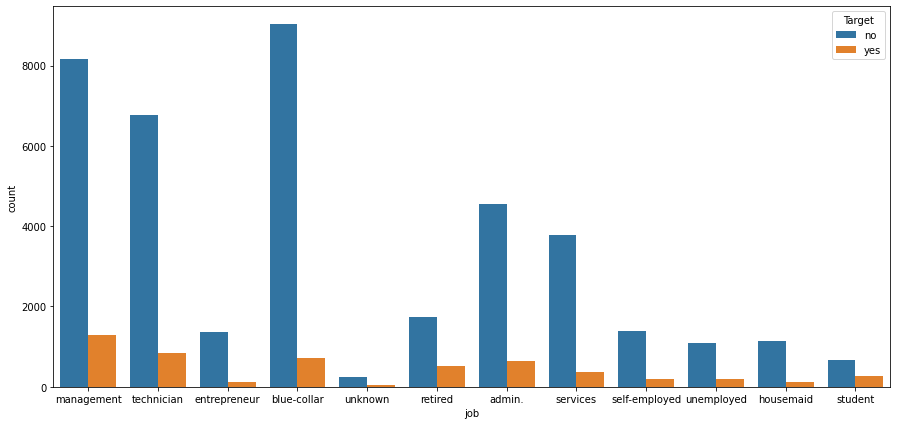

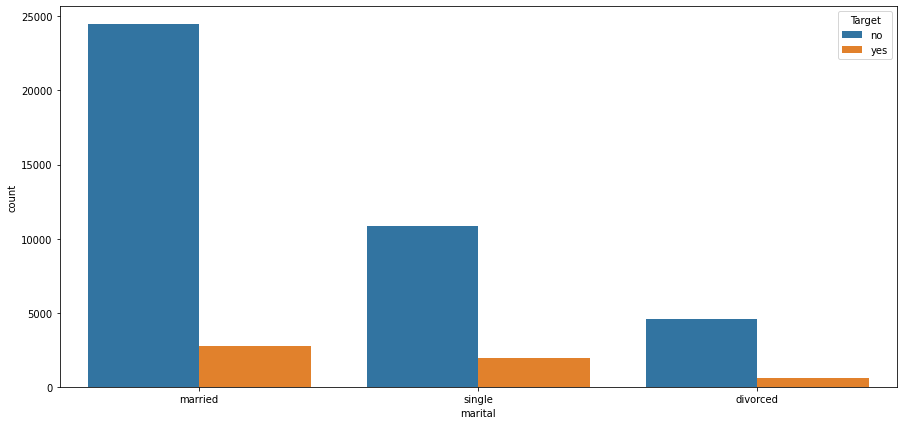

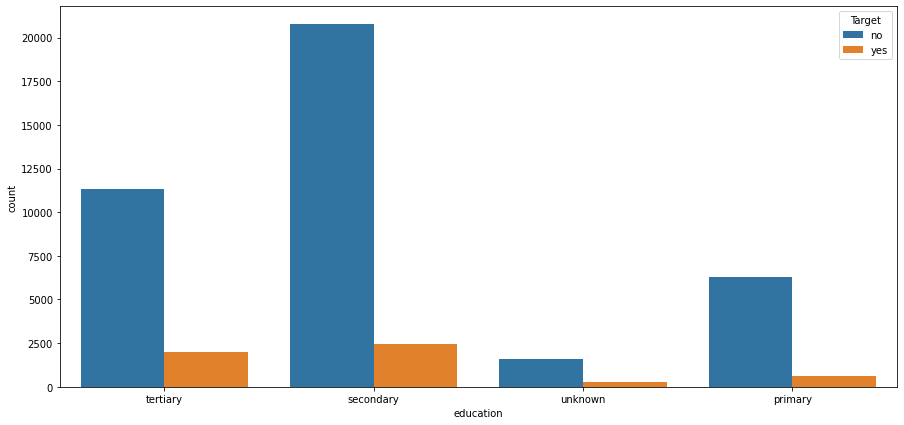

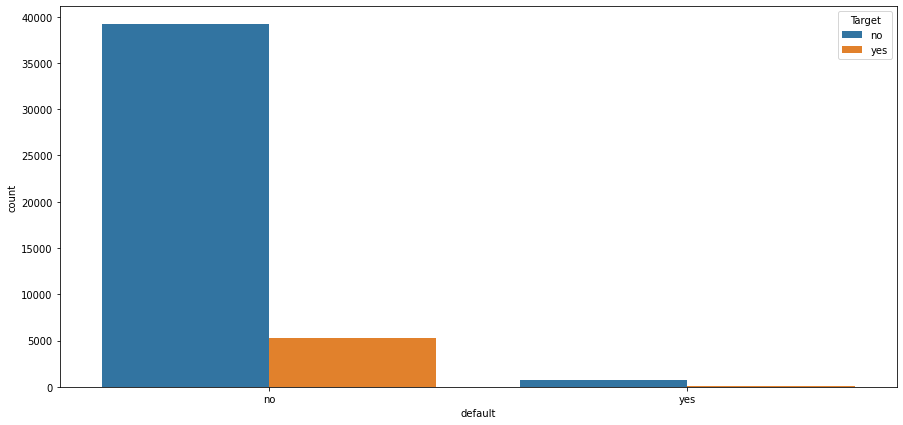

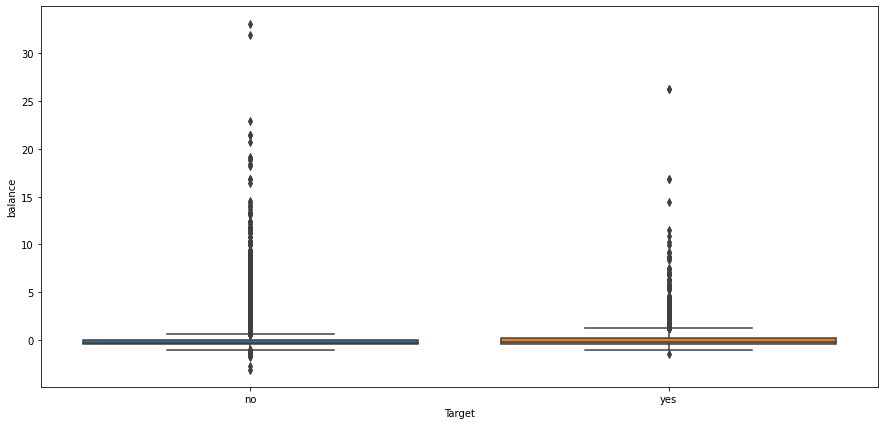

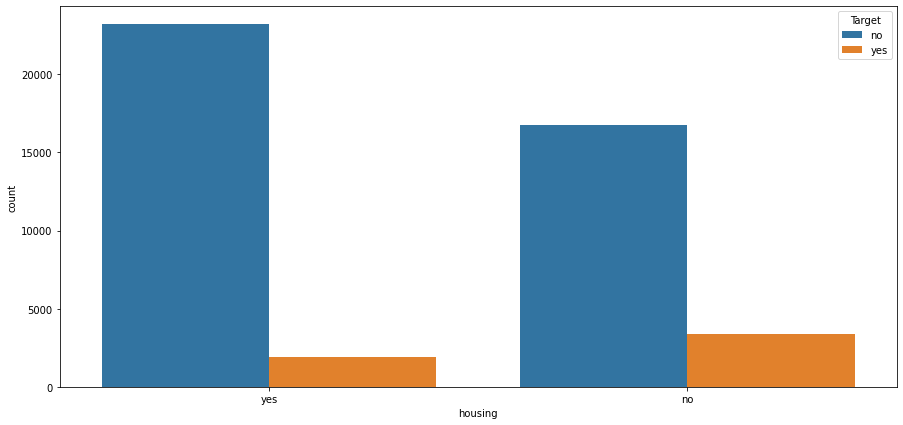

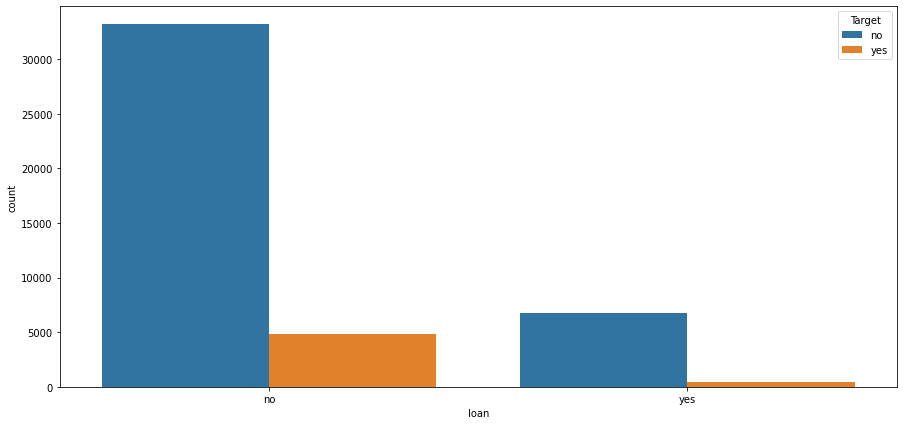

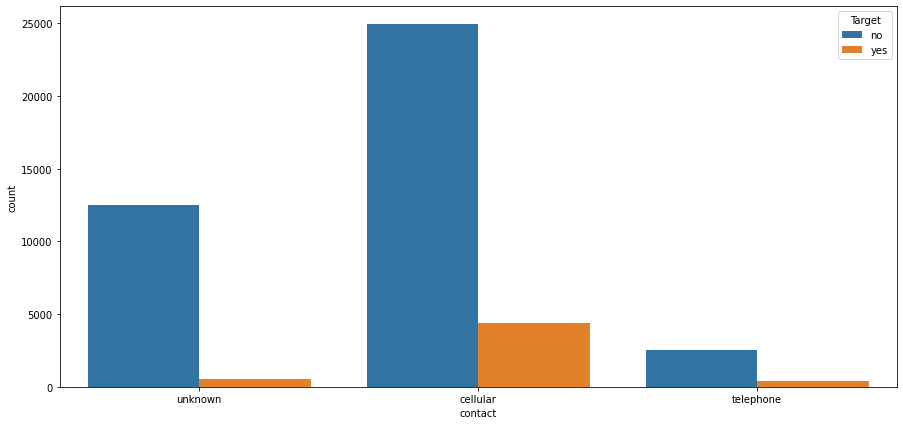

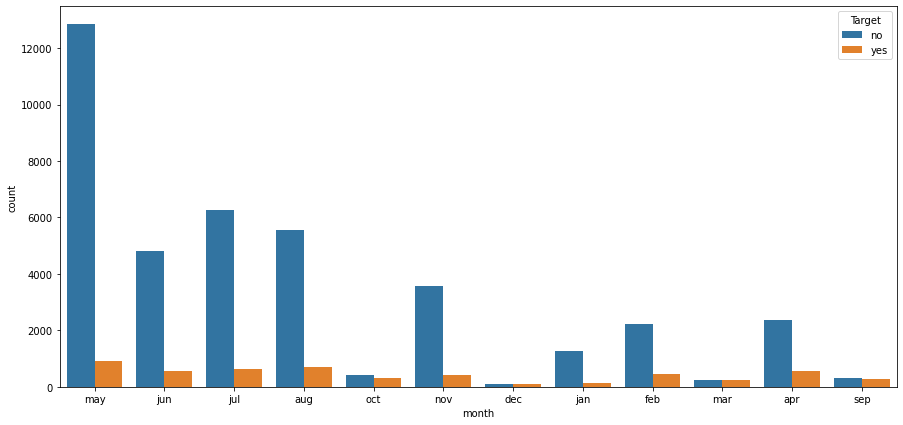

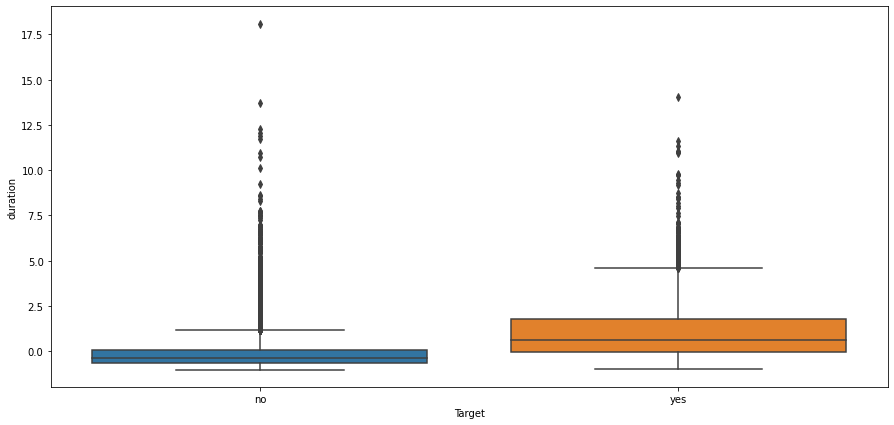

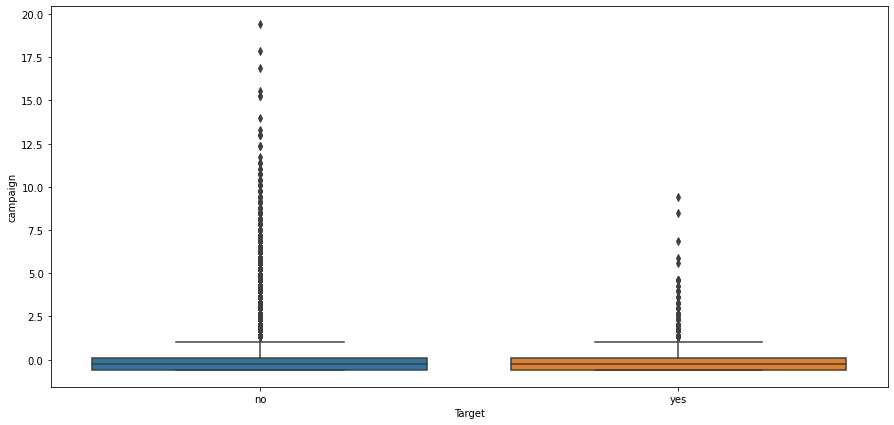

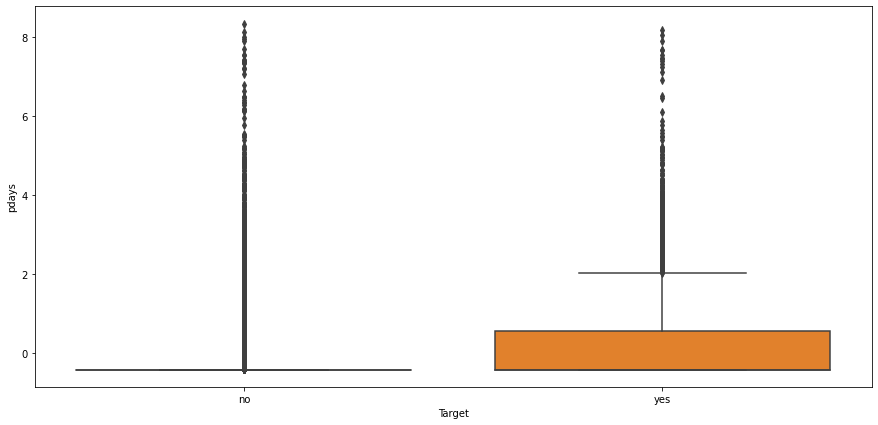

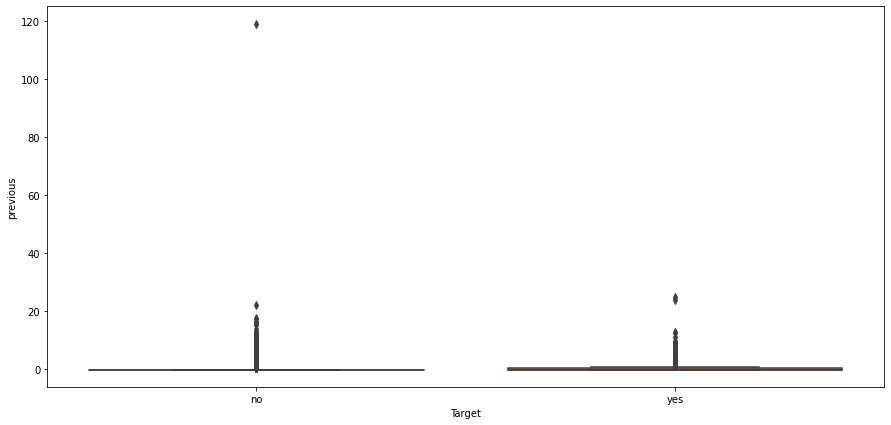

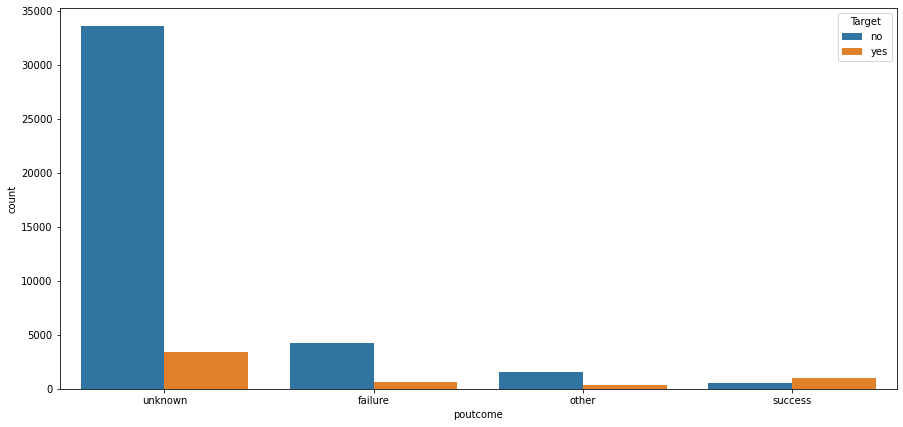

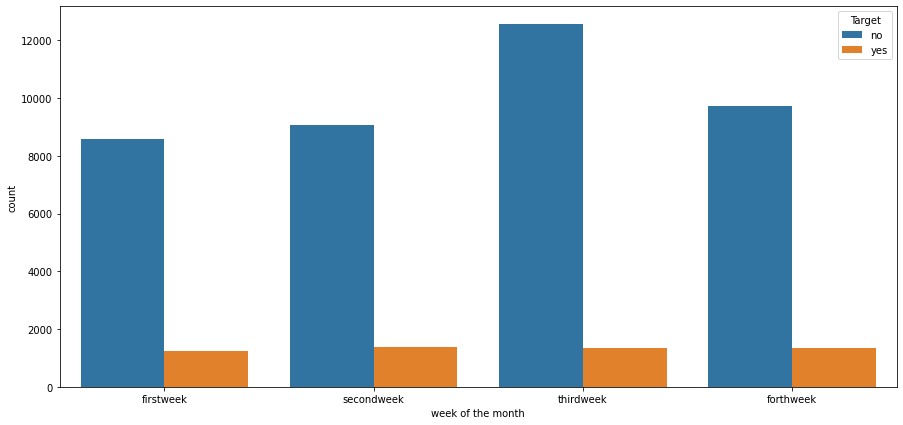

In [19]:
plt.rcParams['figure.figsize'] = (15,7)
#Function to plot boxplots for continuous variable vs target and count plots for categorical variables vs Target
def plot_graphs_feature_vs_target(data):
    for col in data.columns:
        if col == 'Target':
            continue
        if col in numerical_columns:
            sns.boxplot(data['Target'], data[col])
        else:
            sns.countplot(data[col], hue=data['Target'])
        plt.show()
plot_graphs_feature_vs_target(bank_data)

# Insights

1. people in `management` job, subscribed to term deposit more compared to other job types
2. People who are not credit defaulters subscribed more compared to defaulters
3. The longer call duration increases the chance of subscription 

# Bi-variate Analysis

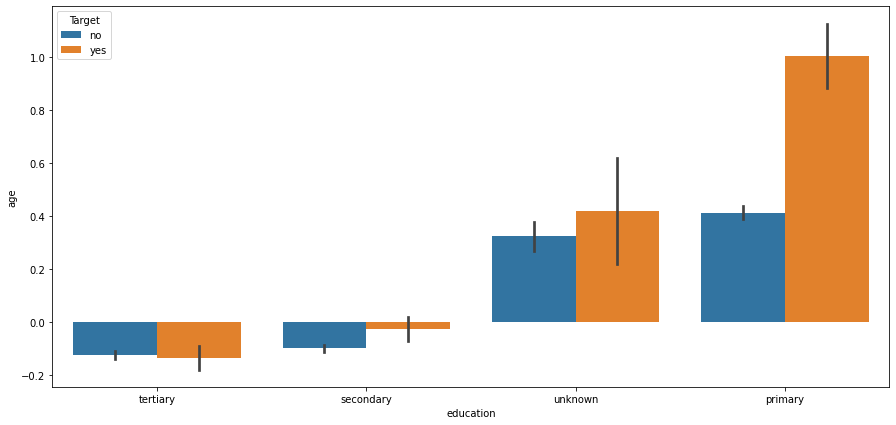

In [20]:
sns.barplot(data=bank_data, x='education', y='age', hue='Target')
plt.show()

# Insight:

People with primary eduction and more age are likely to subscribe for term deposit

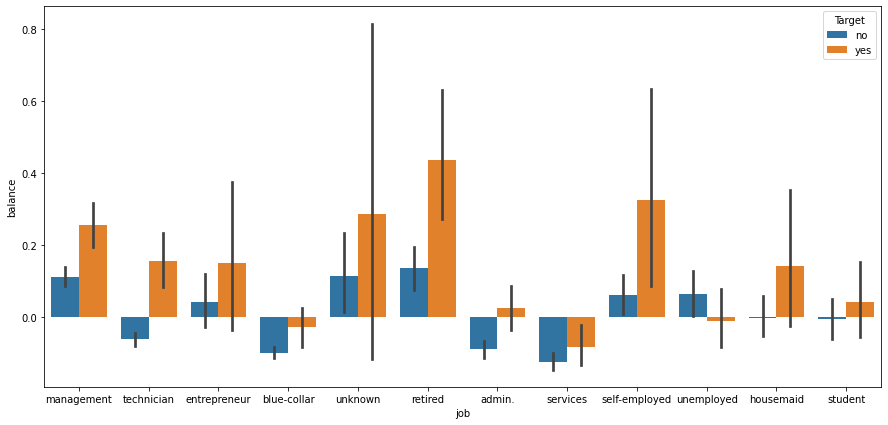

In [21]:
sns.barplot(data=bank_data, x='job', y='balance', hue='Target')
plt.show()

# Insight:

People who retired or self-employed with good balance in the account subscribed for term deposit

In [22]:
bank_data.groupby('Target').mean()

age   balance  duration  campaign     pdays  previous
Target                                                            
no     -0.009156 -0.019232 -0.143599  0.026633 -0.037498 -0.033936
yes     0.069110  0.145167  1.083901 -0.201032  0.283041  0.256154

In [23]:
pd.crosstab(bank_data['housing'], bank_data['Target'], margins=True)

Target      no   yes    All
housing                    
no       16727  3354  20081
yes      23195  1935  25130
All      39922  5289  45211

In [24]:
pd.crosstab(bank_data['loan'], bank_data['Target'], margins=True)

Target     no   yes    All
loan                      
no      33162  4805  37967
yes      6760   484   7244
All     39922  5289  45211

In [25]:
#Map target value from 'yes' and 'no' to 1 and 0 respectively
mapping = {'no':0, 'yes':1}
bank_data['Target'] = bank_data['Target'].replace(mapping) 
bank_data['Target'].astype('int64')
bank_data['Target']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: Target, Length: 45211, dtype: int64

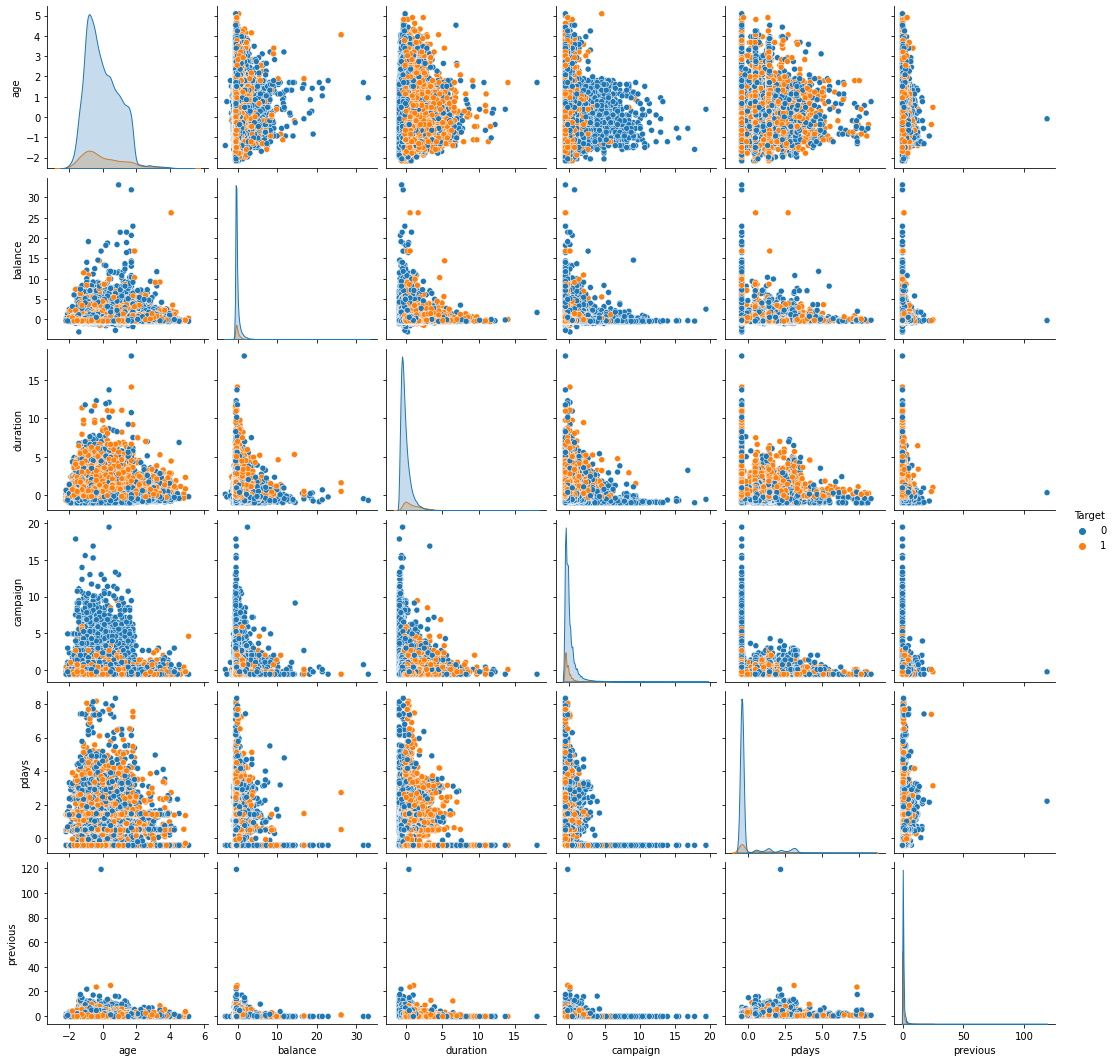

In [26]:
#plot Pairplot
sns.pairplot(bank_data, hue='Target')
plt.show()

<AxesSubplot:>

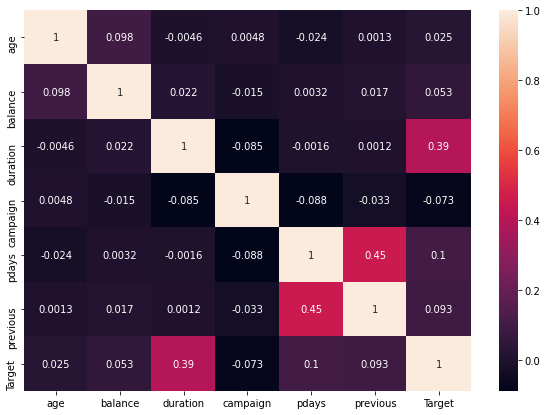

In [27]:
# Plot heatmaps
plt.figure(figsize=(10,7))
sns.heatmap(bank_data.corr(), annot=True)

`There is not much co-relation between features and target variable as well as not much co-relation among features`

# Data Preparation

In [28]:
numerical_columns, categorical_columns = get_categorical_and_numerical_columns()
categorical_columns

['default',
 'housing',
 'month',
 'loan',
 'marital',
 'week of the month',
 'job',
 'contact',
 'education',
 'poutcome']

I am going to create dummy variables for all the category variables instead of using label encoding. Because label encoding will convert the categorical values in to numerical values.  For example: The values of <b>contact</b> column can be label encoded as <b>1 for cellular, 2 for telephone and 3 for unknown</b>. Which will cause model to misinterpret that there exists an order among the values but they are just categorical values with no relation between them.

In [29]:
bank_data = pd.get_dummies(bank_data, columns=categorical_columns)
bank_data.head()

age   balance  duration  campaign    pdays  previous  Target  \
0  1.606965  0.256419  0.011016 -0.569351 -0.41056  -0.25194       0   
1  0.288529 -0.437895 -0.416127 -0.569351 -0.41056  -0.25194       0   
2 -0.747384 -0.446762 -0.707361 -0.569351 -0.41056  -0.25194       0   
3  0.571051  0.047205 -0.645231 -0.569351 -0.41056  -0.25194       0   
4 -0.747384 -0.447091 -0.233620 -0.569351 -0.41056  -0.25194       0   

   default_no  default_yes  housing_no  ...  contact_telephone  \
0           1            0           0  ...                  0   
1           1            0           0  ...                  0   
2           1            0           0  ...                  0   
3           1            0           0  ...                  0   
4           1            0           1  ...                  0   

   contact_unknown  education_primary  education_secondary  \
0                1                  0                    0   
1                1                  0                    1   
2                1                  0                    1   
3                1                  0                    0   
4                1                  0                    0   

   education_tertiary  education_unknown  poutcome_failure  poutcome_other  \
0                   1                  0                 0               0   
1                   0                  0                 0               0   
2                   0                  0                 0               0   
3                   0                  1                 0               0   
4                   0                  1                 0               0   

   poutcome_success  poutcome_unknown  
0                 0                 1  
1                 0                 1  
2                 0                 1  
3                 0                 1  
4                 0                 1  

[5 rows x 55 columns]

In [30]:
# Splitting the data into train and test with 70:30 ratio using a random_state = 7
X = bank_data.drop('Target', axis=1)
y = bank_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=7)

In [31]:
#Function to return class level data distribution percentage
def find_percent_of_class_dist(data, col):
    if isinstance(data, pd.DataFrame):
        no_percentage = (len(data[data[col]==0])/len(data))*100
        yes_percentage = (len(data[data[col]==1])/len(data))*100
    else:
        no_percentage = (len(data[data==0])/len(data))*100
        yes_percentage = (len(data[data==1])/len(data))*100
    return no_percentage, yes_percentage
no_percentage, yes_percentage = find_percent_of_class_dist(bank_data, 'Target')
print('the percentage of no: {} and yes: {} values in the whole data set'.format(no_percentage, yes_percentage))
no_percentage, yes_percentage = find_percent_of_class_dist(y_train, None)
print('the percentage of no: {} and yes: {} values in the train data set'.format(no_percentage, yes_percentage ))
no_percentage, yes_percentage = find_percent_of_class_dist(y_test, None)
print('the percentage of no: {} and yes: {} values in the test data set'.format(no_percentage, yes_percentage ))


the percentage of no: 88.30151954170445 and yes: 11.698480458295547 values in the whole data set
the percentage of no: 88.1347363099188 and yes: 11.865263690081209 values in the train data set
the percentage of no: 88.69065172515482 and yes: 11.309348274845178 values in the test data set


`We can say the class distribution is same among the whole data, train and test data sets`

In [32]:
#get the outliers in training data
outliers_in_train_data = get_outliers(X_train)
outliers_in_train_data

age                                0
balance                            0
campaign                         591
contact_cellular                   0
contact_telephone                  0
contact_unknown                    0
default_no                         0
default_yes                        0
duration                           0
education_primary                  0
education_secondary                0
education_tertiary                 0
education_unknown                  0
housing_no                         0
housing_yes                        0
job_admin.                         0
job_blue-collar                    0
job_entrepreneur                   0
job_housemaid                      0
job_management                     0
job_retired                        0
job_self-employed                  0
job_services                       0
job_student                        0
job_technician                     0
job_unemployed                     0
job_unknown                        0
l

In [33]:
# Now that we split the data into train and test, lets fix the outliers in training data before fitting the model
for col in columns_with_outliers:
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3 - q1
    upper_wisker = q3 + 1.5 * iqr
    lower_wisker = q1 - 1.5 * iqr
    #Replace the lower-end outliers with lower wisker
    X_train[col] = np.where(X_train[col] < lower_wisker, lower_wisker, X_train[col])
    
     #Replace the upper-end outliers with upper wisker
    X_train[col] = np.where(X_train[col] > upper_wisker, upper_wisker, X_train[col])

NameError: name 'columns_with_outliers' is not defined

In [ ]:
outliers_in_train_data_after_capping = get_outliers(X_train)
outliers_in_train_data_after_capping

# Model Creation

# Decision Tree

In [38]:
dTree = DecisionTreeClassifier(criterion='gini', random_state=7)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=7)

In [39]:
print('Train score of Decision tree: {}'. format(dTree.score(X_train, y_train)))
print('Test score of Decision tree: {}'. format(dTree.score(X_test, y_test)))

Train score of Decision tree: 1.0
Test score of Decision tree: 0.8718667059864347


In [40]:
#Function to visualize the tree
def plot_tree_graph(dTree):
    bank_data_tree = open('bank_data_tree.dot','w')
    bank_data_dot = tree.export_graphviz(dTree, out_file=bank_data_tree, feature_names=X_train.columns)
    bank_data_tree.close()
    with open("bank_data_tree.dot") as f:
        dot_graph = f.read()
    display(graphviz.Source(dot_graph))
plot_tree_graph(dTree)

In [41]:
# The above tree is overfit with training data, so lets prune the tree to avoid overfit
dTree_pruned = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=50, random_state=7)
dTree_pruned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=7)

In [42]:
print('Train score of pruned Decision tree: {}'. format(dTree_pruned.score(X_train, y_train)))
print('Test score of pruned Decision tree: {}'. format(dTree_pruned.score(X_test, y_test)))

Train score of pruned Decision tree: 0.9010648718677916
Test score of pruned Decision tree: 0.9027572987319374


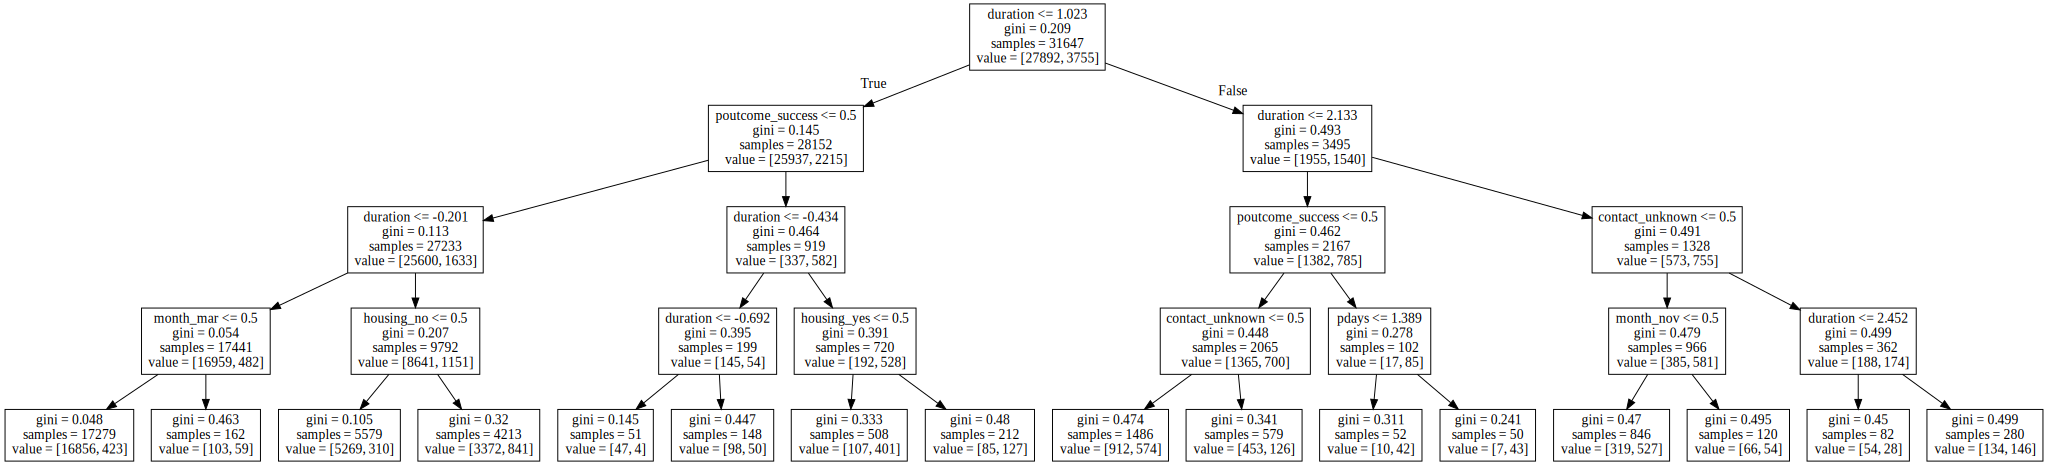

In [43]:
#plot the pruned tree
plot_tree_graph(dTree_pruned)

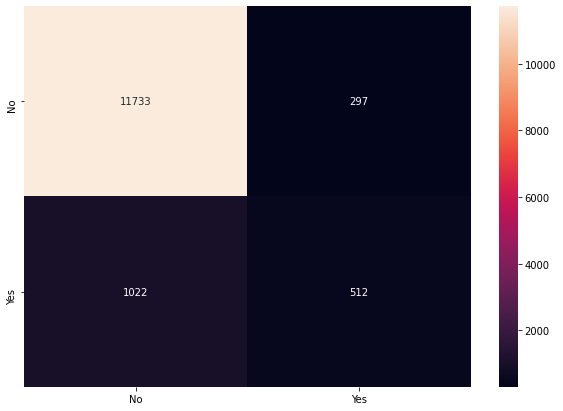

In [44]:
#predict using test data
y_predict = dTree_pruned.predict(X_test)

#Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_predict):
    conf_matrix = confusion_matrix(y_test, y_predict)

    df_cm = pd.DataFrame(conf_matrix, index = [i for i in ["No","Yes"]],
                      columns = [i for i in ["No","Yes"]])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True ,fmt='g')
    plt.show()

plot_confusion_matrix(y_test, y_predict)

In [45]:
#Create a result dataframe with model as index and performance metrics as columns
result_df = pd.DataFrame(columns=['train_score', 'test_score', 'precision', 'recall'])

#Function to update the result Dataframe
def update_result_df(train_score, y_test, y_predict, method_name):
    result_df.loc[method_name] = [train_score, accuracy_score(y_test, y_predict), precision_score(y_test, y_predict), recall_score(y_test, y_predict)]
    return result_df
result_df = update_result_df(dTree_pruned.score(X_train, y_train), y_test, y_predict, 'Decision Tree')
result_df.head()

train_score  test_score  precision    recall
Decision Tree     0.901065    0.902757    0.63288  0.333768

In [46]:
print('Decision Tree class level metrics:')
print(classification_report(y_test, y_predict))

Decision Tree class level metrics:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12030
           1       0.63      0.33      0.44      1534

    accuracy                           0.90     13564
   macro avg       0.78      0.65      0.69     13564
weighted avg       0.89      0.90      0.89     13564



# Bagging Classifier

In [47]:
bagging_classifier = BaggingClassifier(base_estimator=dTree, n_estimators=50, random_state=7)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),
                  n_estimators=50, random_state=7)

In [48]:
print('Train score of Bagging Classifier: {}'. format(bagging_classifier.score(X_train, y_train)))
print('Test score of Bagging Classifier: {}'. format(bagging_classifier.score(X_test, y_test)))

Train score of Bagging Classifier: 0.9996208171390654
Test score of Bagging Classifier: 0.9054113830728399


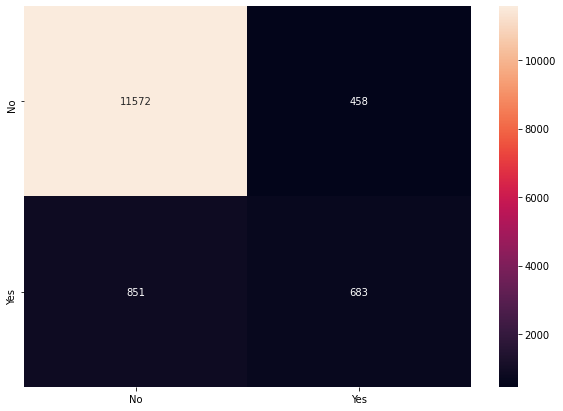

In [180]:
#predict using test data
y_predict = bagging_classifier.predict(X_test)

#plot confusion matrix
plot_confusion_matrix(y_test, y_predict)

In [181]:
#update result dataframe
result_df = update_result_df(bagging_classifier.score(X_train, y_train), y_test, y_predict, 'Bagging Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree          0.901065    0.902757   0.632880  0.333768
Bagging Classifier     0.999652    0.903495   0.598598  0.445241

In [182]:
print('Bagging classifier class level metrics:')
print(classification_report(y_test, y_predict))

Bagging classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     12030
           1       0.60      0.45      0.51      1534

    accuracy                           0.90     13564
   macro avg       0.77      0.70      0.73     13564
weighted avg       0.89      0.90      0.90     13564



# AdaBoost Classifier

In [183]:
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=7)
adaboost_classifier.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=7)

In [184]:
print('Train score of AdaBoost Classifier: {}'. format(adaboost_classifier.score(X_train, y_train)))
print('Test score of AdaBoost Classifier: {}'. format(adaboost_classifier.score(X_test, y_test)))

Train score of AdaBoost Classifier: 0.901602047587449
Test score of AdaBoost Classifier: 0.904452963727514


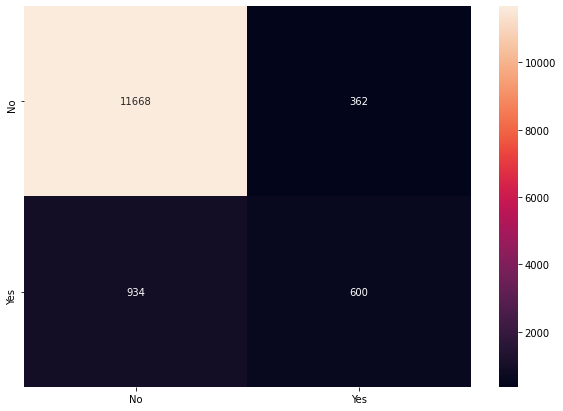

In [185]:
#predict using test data
y_predict = adaboost_classifier.predict(X_test)
#Plot confusion matrix
plot_confusion_matrix(y_test, y_predict)

In [186]:
#update result dataframe
result_df = update_result_df(adaboost_classifier.score(X_train, y_train), y_test, y_predict, 'AdaBoost Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree           0.901065    0.902757   0.632880  0.333768
Bagging Classifier      0.999652    0.903495   0.598598  0.445241
AdaBoost Classifier     0.901602    0.904453   0.623701  0.391134

In [187]:
print('AdaBoost Classifier class level metrics:')
print(classification_report(y_test, y_predict))

AdaBoost Classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.62      0.39      0.48      1534

    accuracy                           0.90     13564
   macro avg       0.77      0.68      0.71     13564
weighted avg       0.89      0.90      0.89     13564



# GradientBoost Classifier

In [188]:
gradientboost_classifier = GradientBoostingClassifier(n_estimators=120, learning_rate=0.3, random_state=7)
gradientboost_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=120, random_state=7)

In [189]:
print('Train score of Gradientboost Classifier: {}'. format(gradientboost_classifier.score(X_train, y_train)))
print('Test score of Gradientboost Classifier: {}'. format(gradientboost_classifier.score(X_test, y_test)))

Train score of Gradientboost Classifier: 0.9238474420956173
Test score of Gradientboost Classifier: 0.908950162194043


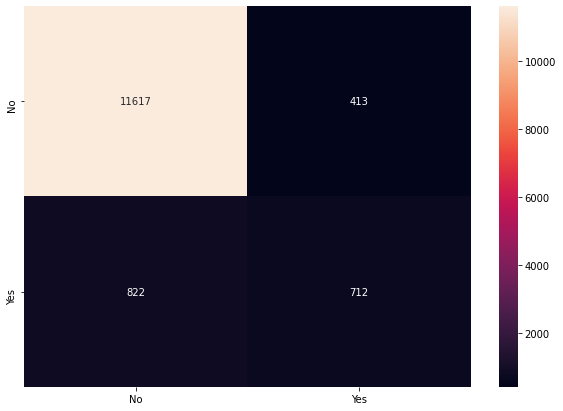

In [190]:
#predict using test data
y_predict = gradientboost_classifier.predict(X_test)

#plot confusion matrix
plot_confusion_matrix(y_test, y_predict)

In [191]:
#update result dataframe
result_df = update_result_df(gradientboost_classifier.score(X_train, y_train), y_test, y_predict, 'GradientBoost Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree                0.901065    0.902757   0.632880  0.333768
Bagging Classifier           0.999652    0.903495   0.598598  0.445241
AdaBoost Classifier          0.901602    0.904453   0.623701  0.391134
GradientBoost Classifier     0.923847    0.908950   0.632889  0.464146

In [192]:
print('GradientBoost Classifier class level metrics:')
print(classification_report(y_test, y_predict))

GradientBoost Classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.63      0.46      0.54      1534

    accuracy                           0.91     13564
   macro avg       0.78      0.71      0.74     13564
weighted avg       0.90      0.91      0.90     13564



# RandomForest Classifier

In [193]:
randomforest_classifier = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=7)
randomforest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

In [194]:
print('Train score of RandomForest Classifier: {}'. format(randomforest_classifier.score(X_train, y_train)))
print('Test score of RandomForest Classifier: {}'. format(randomforest_classifier.score(X_test, y_test)))

Train score of RandomForest Classifier: 0.9999684014282555
Test score of RandomForest Classifier: 0.9075493954585668


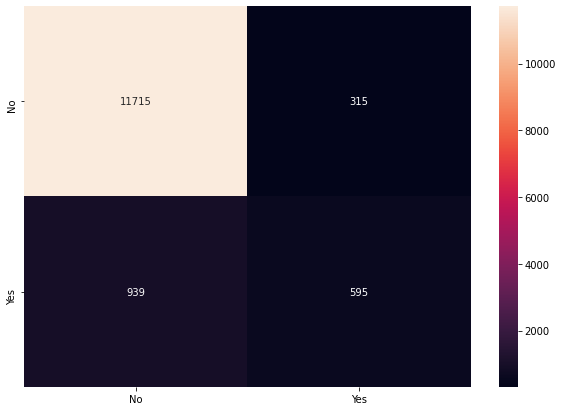

In [195]:
#predict using test data
y_predict = randomforest_classifier.predict(X_test)

#plot confusion matrix
plot_confusion_matrix(y_test, y_predict)

In [196]:
#update result dataframe
result_df = update_result_df(randomforest_classifier.score(X_train, y_train), y_test, y_predict, 'RandomForest Classifier')
result_df.head()

train_score  test_score  precision    recall
Decision Tree                0.901065    0.902757   0.632880  0.333768
Bagging Classifier           0.999652    0.903495   0.598598  0.445241
AdaBoost Classifier          0.901602    0.904453   0.623701  0.391134
GradientBoost Classifier     0.923847    0.908950   0.632889  0.464146
RandomForest Classifier      0.999968    0.907549   0.653846  0.387875

In [197]:
print('RandomForest Classifier class level metrics:')
print(classification_report(y_test, y_predict))

RandomForest Classifier class level metrics:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12030
           1       0.65      0.39      0.49      1534

    accuracy                           0.91     13564
   macro avg       0.79      0.68      0.72     13564
weighted avg       0.90      0.91      0.90     13564



# Confusion Matrix Metrics:

<ol>
    <li><b> Precision</b> - It tells that out of  total number of True predictions by the model, what fraction of them are actually true. 
        <b><i>Precision = TP/(TP+FP)</i></b></li>
    <li><b> Recall</b> - It tells that out of total number of Actual True labels, what fraction of them the model predicted true. 
        <b><i>Recall = TP/(TP+FN)</i></b></li>
</ol>

<p>The objective of the project is to help the marketing team identify potential customers who are relatively more likely to subscribe to the term deposit and this increase the hit ratio.</p>

<p>For our objective, if the model predicts that a customer will subscribe for term deposit and the customer ended up not subscribing is less costly compared to the model predicted that a customer is not going to subscribe but ended up subscribing for Term Deposit.</p>

<p>Having more False Negatives will be constly for the bank. So we need to reduce Fallse Negatives. Since Recall deals with False Negatives, we need to look at <b><i>Recall</i></b> metric while evaluting the model performance.</p>


# Among all the five models above, The Gradient Boost Classifier gives the best recall with a recall score of 46.4%, also its not overfit with train data.  So we will choose <b><i><u>GradientBoost Classifier model</u></i></b>

# What do you mean by recall and what information does it provide here?

Recall gives the fraction of predictions that are correctly classified by the model.

It gives a measure of how accurately the model is able to identify the relavant class in our case, Term Deposit Subscription

In [199]:
#finding the importance of features
pd.DataFrame(gradientboost_classifier.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

importance
duration                        0.436721
poutcome_success                0.151940
age                             0.045493
month_mar                       0.032881
contact_unknown                 0.030998
poutcome_unknown                0.028548
month_jun                       0.027576
month_apr                       0.027418
balance                         0.026376
housing_yes                     0.023028
month_oct                       0.021041
housing_no                      0.018844
month_sep                       0.018742
month_nov                       0.013087
week of the month_forthweek     0.012300
week of the month_firstweek     0.010271
month_feb                       0.010161
campaign                        0.007473
contact_cellular                0.006584
month_dec                       0.005562
week of the month_thirdweek     0.005033
month_aug                       0.003550
week of the month_secondweek    0.003389
education_tertiary              0.003367
marital_married                 0.003141
job_student                     0.002693
month_may                       0.002448
month_jul                       0.002219
education_unknown               0.002198
job_entrepreneur                0.001977
poutcome_failure                0.001839
job_housemaid                   0.001835
job_services                    0.001719
education_secondary             0.001489
job_unknown                     0.001201
education_primary               0.001180
loan_no                         0.001152
month_jan                       0.000980
poutcome_other                  0.000907
job_admin.                      0.000683
marital_divorced                0.000522
job_blue-collar                 0.000374
loan_yes                        0.000325
job_retired                     0.000287
job_unemployed                  0.000261
job_management                  0.000129
default_no                      0.000035
job_self-employed               0.000022
job_technician                  0.000002
marital_single                  0.000000
contact_telephone               0.000000
previous                        0.000000
pdays                           0.000000
default_yes                     0.000000

# Suggest some changes for the organization so that they can increase the number of customers who take term deposit.

To increase the number of customers who take term deposit,

1. Bank should have longer duration calls to talk through customers
2. Should target more on customers who subscribed for previous campagin

# How much influence does the previous campaign and mode of interaction have on financial performance?

1. It seems customers who subscribed in the previous campaign there is a chance that they might subscribe for term deposit.

2. The contact method phone or telephone doesn't seems to have an imapact on term deposit subscription

# Which features should be more/less focused by the bank to get better results and why?

<p>duration, previous outcome other than failure, age of the customer,contacting the customers in month of march, april,jun and october, people with housing loan seems to have good impact on the target variable. Hence, bank should focus more on these features while targetting customers for term deposit subscription.</p>

<p>Other features like marital status, education, job, default, loan, previous, pdays doesn't seems to have much impact on the target variable, Bank should focus less on these features</p>

# What did you learn about banking industries from this data?

1. Banks allows overdraft. I see negative values for account balance

2. Banks have challenge of collecting proper data, i see there are lot of unknowns in the data

3. Banks try to run different campaigns time to time and try to personalize those campaigns as per their customer needs
